In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from unidecode import unidecode

pd.options.display.float_format = "{:,.2f}".format
sns.set_theme(style='white')

# Config

In [17]:
# PATH_SAMPLES = 'data/reference/banco_14_amostraDMR_preenchido.xlsx'
PATH_SAMPLES = 'data/reference/banco_14_amostraDMR_preenchido.xlsx'

PATH_DATAFRAME = 'data/banco_carnes_un_v9_ed.parquet'

TARGET_FIELDS_SP = ['dados.n_doc', 'item','qt_nova', 'valor_kg', 'valor','valor_novo']

TARGE_FIELDS_DF = ['dados.n_doc', 'item','unit_kg', 'price_kg', 'valor']

CODE = 14

# Input

In [18]:
df_samples = pd.read_excel(PATH_SAMPLES).fillna(0).query('valor_kg > 0')

df_samples['item'] = df_samples['item'].str.upper().apply(unidecode)

df_products = pd.read_parquet(PATH_DATAFRAME).query(f'codigo == {CODE} and rule_apply == 1 and outlier == 0')

# Merge Dataframes

In [19]:
df_products['valor_novo_s'] = df_products['price_kg'].mul(df_products['unit_kg'])

df_merged = df_samples.merge(
    df_products, 
    how='left', 
    on=['...1', 'ano', 'item', 'valor']
)

df_merged = df_merged.query('not has_change.isna()', engine='python')

# Compute Diff

In [20]:
df_merged['price_kg_diff'] = df_merged['valor_kg'].subtract(df_merged['price_kg'])
df_merged['valor_diff'] = df_merged['valor_novo'].subtract(df_merged['valor_novo_s'])
df_merged['qt_diff'] = df_merged['qt_nova'].subtract(df_merged['unit_kg'])

In [21]:
df_merged[['...1', 'ano', 'item', 'valor_kg', 'price_kg', 'qt_nova','unit_kg']]

,...1,ano,item,valor_kg,price_kg,qt_nova,unit_kg
0,30920,2018,"FRANGO, FILE",9.20,8.80,5.00,5.23
1,13968,2013,"FRANGO INTEIRO, COM PELE",5.95,5.99,33.00,32.78
2,30860,2018,"FRANGO PEITO, COM PELE",10.45,7.45,70.00,98.19
3,744,2019,"FRANGO, PEITO, DIVERSOS CORTES, RESFRIADO/CONG...",6.54,8.40,35.00,27.25
4,7296,2016,"FRANGO, PEITO, DIVERSOS CORTES, RESFRIADO/CONG...",6.73,6.73,54.00,54.00
...,...,...,...,...,...,...,...
1339,503,2015,"FRANGO INTEIRO, RESFRIADO/CONGELADO",7.50,7.50,354.00,354.00
1340,39513,2019,FILE DE PEITO DE FRANGO,9.35,9.35,160.00,160.00
1341,18175,2015,"FRANGO, PEITO, DIVERSOS CORTES, RESFRIADO/CONG...",6.47,6.47,836.00,836.00
1342,12646,2016,"FRANGO INTEIRO, RESFRIADO/CONGELADO",4.79,4.79,88.00,88.00


# Change DF structure

In [22]:
df_price_un = df_merged[['ano','price_kg', 'valor_kg']]\
    .melt(id_vars=['ano'], value_vars=['price_kg', 'valor_kg'], var_name='type')\
	.replace({'type': {'price_kg': 'Estimado', 'valor_kg': 'Amostra'}})

df_qt = df_merged[['ano','qt_nova', 'unit_kg']]\
    .melt(id_vars=['ano'], value_vars=['qt_nova', 'unit_kg'], var_name='type')\
	.replace({'type': {'unit_kg': 'Estimado', 'qt_nova': 'Amostra'}})

df_valor = df_merged[['ano','valor_novo', 'valor_novo_s']]\
    .melt(id_vars=['ano'], value_vars=['valor_novo', 'valor_novo_s'], var_name='type')\
	.replace({'type': {'valor_novo_s': 'Estimado', 'valor_novo': 'Amostra'}})

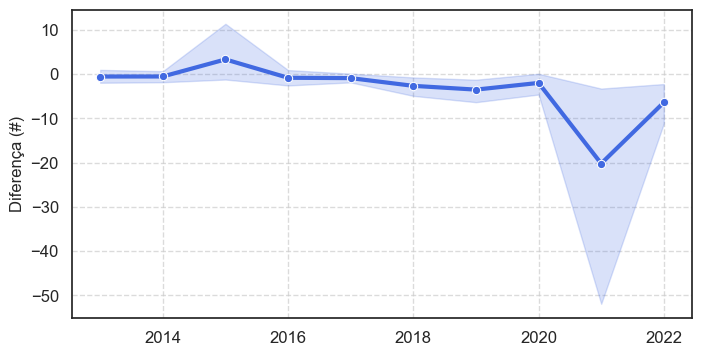

In [23]:
# Criar figura
plt.figure(figsize=(8, 4))

# Criar gráfico de linha com melhorias
sns.lineplot(
    data=df_merged, 
    x='ano', 
    y='qt_diff', 
    marker="o",  # Adiciona marcadores nos pontos
    linewidth=3,  # Linhas mais espessas
    color="royalblue"  # Cor mais destacada
)

# Ajustar eixos
plt.xlabel('')
plt.ylabel('Diferença (#)', fontsize=12)
#plt.ylim(0, 10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Melhorar layout
plt.grid(True, linestyle="--", alpha=0.7)  # Grade mais discreta

plt.savefig(f'data/figures/{CODE}_difference_qt.png')
plt.show()

# Display charts

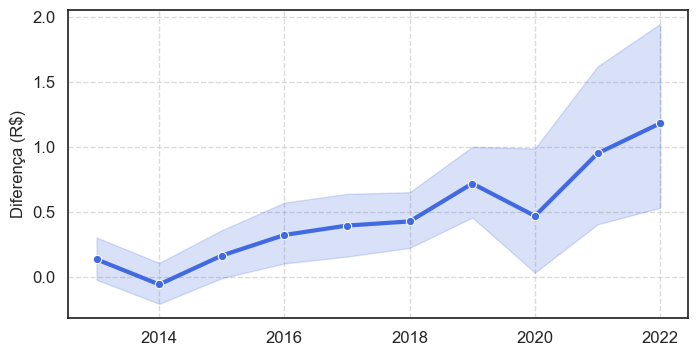

In [24]:
# Criar figura
plt.figure(figsize=(8, 4))

# Criar gráfico de linha com melhorias
sns.lineplot(
    data=df_merged, 
    x='ano', 
    y='price_kg_diff', 
    marker="o",  # Adiciona marcadores nos pontos
    linewidth=3,  # Linhas mais espessas
    color="royalblue"  # Cor mais destacada
)

# Ajustar eixos
plt.xlabel('')
plt.ylabel('Diferença (R$)', fontsize=12)
#plt.ylim(0, 10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Melhorar layout
plt.grid(True, linestyle="--", alpha=0.7)  # Grade mais discreta

plt.savefig(f'data/figures/{CODE}_difference_price_kg.png')
plt.show()

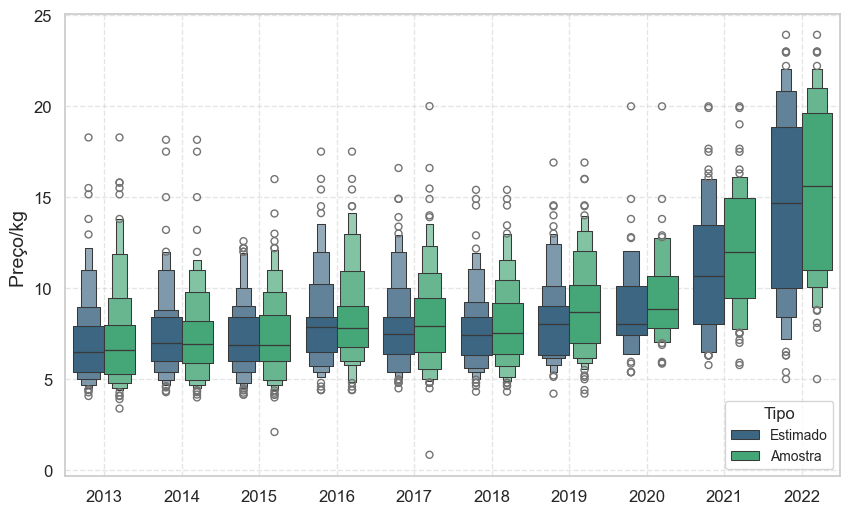

In [25]:
import seaborn as sns
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))


sns.boxenplot(
    data=df_price_un, 
    x="ano", 
    y="value",
    hue="type", 
    width_method="linear",
    palette="viridis"  
)


plt.xlabel('')
plt.ylabel('Preço/kg ', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Melhorar legenda
plt.legend(title="Tipo", loc="lower right", fontsize=10, title_fontsize=12)

# Melhorar grade
plt.grid(True, linestyle="--", alpha=0.5)


plt.savefig(f'data/figures/{CODE}_comparasion_price_kg.png')
# Exibir gráfico
plt.show()



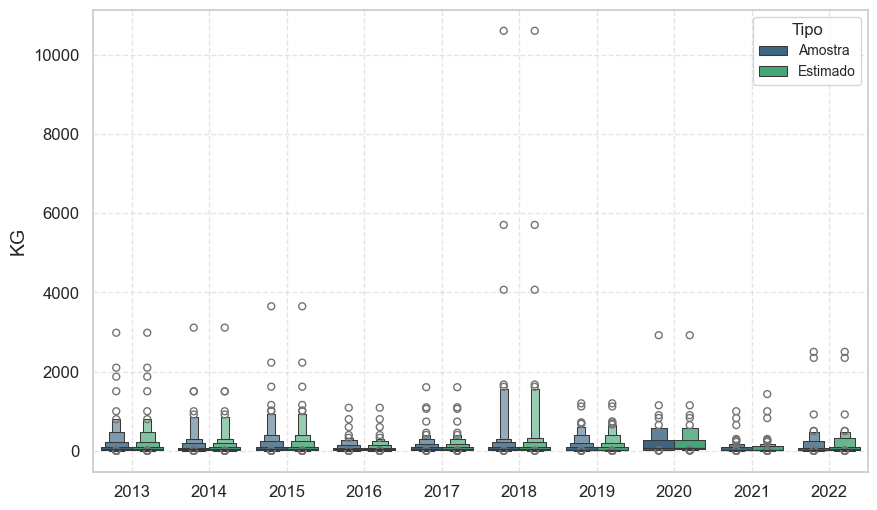

In [26]:
import seaborn as sns
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))


sns.boxenplot(
    data=df_qt, 
    x="ano", 
    y="value",
    hue="type", 
    width_method="linear",
    palette="viridis"  
)


plt.xlabel('')
plt.ylabel('KG', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Melhorar legenda
plt.legend(title="Tipo", loc="upper right", fontsize=10, title_fontsize=12)

# Melhorar grade
plt.grid(True, linestyle="--", alpha=0.5)

plt.savefig(f'data/figures/{CODE}_comparasion_count_kg.png')
# Exibir gráfico
plt.show()



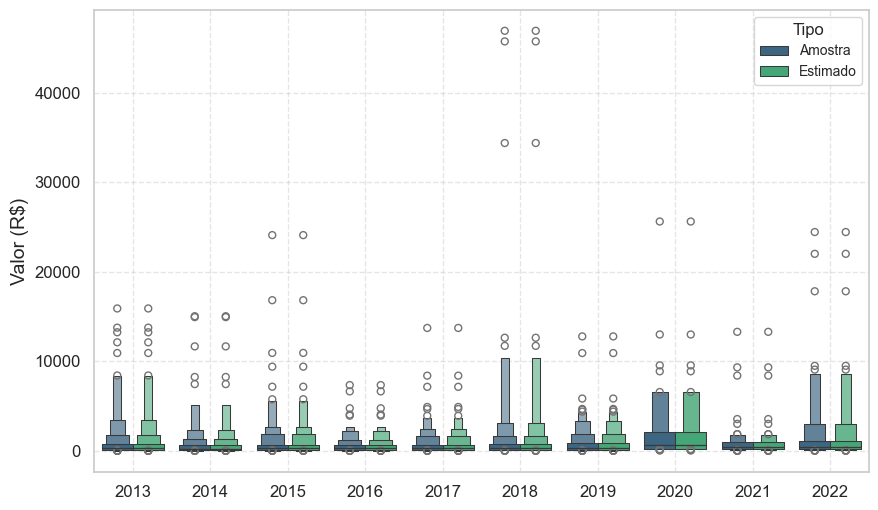

In [27]:
import seaborn as sns
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))


sns.boxenplot(
    data=df_valor, 
    x="ano", 
    y="value",
    hue="type", 
    width_method="linear",
    palette="viridis"  
)


plt.xlabel('')
plt.ylabel('Valor (R$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Melhorar legenda
plt.legend(title="Tipo", loc="upper right", fontsize=10, title_fontsize=12)

# Melhorar grade
plt.grid(True, linestyle="--", alpha=0.5)



plt.savefig(f'data/figures/{CODE}_comparasion_valor_kg.png')
# Exibir gráfico
plt.show()


In [28]:
df_merged.to_csv(f'data/comparacoes/produto_{CODE}_comparacao.csv')

# 

In [29]:
df_merged.columns

Index(['...1', 'ano', 'UF_x', 'municipio_x', 'dados.fornecedor_x',
       'dados.CNPJ.CPF_x', 'dados.tipo_x', 'dados.n_doc_x', 'dados.emissao_x',
       'valor_total_nota_fiscal_x', 'item', 'un_x', 'qt_x', 'qt_nova',
       'valor_un_x', 'valor_kg', 'valor_novo', 'valor', 'codigo_x', 'corte_x',
       'UF_y', 'municipio_y', 'dados.fornecedor_y', 'dados.CNPJ.CPF_y',
       'dados.tipo_y', 'dados.n_doc_y', 'dados.emissao_y',
       'valor_total_nota_fiscal_y', 'un_y', 'qt_y', 'valor_un_y', 'codigo_y',
       'corte_y', 'deflator_acum', 'valor_real', 'cluster', 'valor_real_USD',
       'produtos', 'un_adj', 'has_change', 'unit_kg', 'price_kg',
       'median_price', 'rule_apply', 'outlier', 'rule_version', 'rule_id',
       'valor_un_ref', 'valor_novo_s', 'price_kg_diff', 'valor_diff',
       'qt_diff'],
      dtype='object')